In [1]:
import sys
sys.path.append('..')
from clf_funcs import setup
from load_datasets import load_image, show_image_with_bbox
from sodnet_funcs import ResBlock, SODNetBuilder, get_adam_loaders

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

import tensorflow as tf

setup()

2023-12-22 01:19:12.593295: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-22 01:19:17.094431: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-22 01:19:17.164438: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-

In [2]:
root = '../../datasets/ADAM/Training1200'
fovea = pd.read_csv(f'{root}/fovea_location.csv', index_col='ID')

display(fovea.head())
display(fovea.tail())

,imgName,Fovea_X,Fovea_Y
ID,,,
0,A0001.jpg,142.495130,127.255264
1,A0001-1.jpg,173.229593,152.780556
2,A0001-2.jpg,142.495130,127.255264
3,A0002.jpg,116.640789,126.623708
4,A0002-1.jpg,116.640789,129.376292


,imgName,Fovea_X,Fovea_Y
ID,,,
1180,N0310-1.jpg,121.887742,147.226449
1181,N0310-2.jpg,121.887742,147.226449
1182,N0311.jpg,132.273929,134.670017
1183,N0311-1.jpg,132.273929,134.670017
1184,N0311-2.jpg,132.273929,134.670017


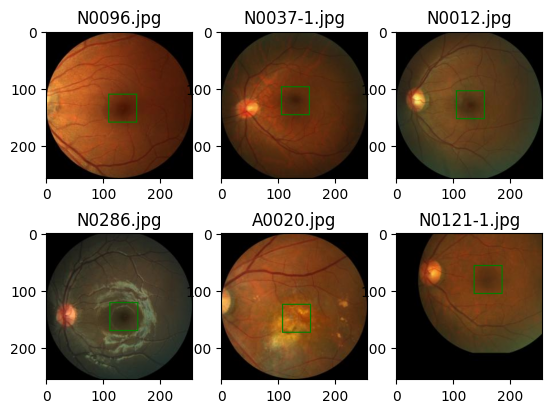

In [3]:
fig, axes = plt.subplots(2, 3)
to_draw = np.random.choice(fovea.index, size=6, replace=False)

for ax, idx in zip(axes.flatten(), to_draw):
	img, bbox = load_image(fovea, idx, root=root)
	show_image_with_bbox(fovea, img, bbox, ax=ax, idx=idx)

In [5]:
train_ds, test_ds = get_adam_loaders(8, 16, cutoff=0.8)
img_batch, bbox_batch = next(iter(train_ds))
print(img_batch.shape, img_batch.dtype)
print(bbox_batch, bbox_batch.dtype)

2023-12-22 01:19:19.108076: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-22 01:19:19.108405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-22 01:19:19.108533: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

(8, 256, 256, 3) <dtype: 'float32'>
tf.Tensor(
[[0.516472   0.5025949 ]
 [0.6909826  0.5140711 ]
 [0.93939394 0.5708608 ]
 [0.4646597  0.5197214 ]
 [0.4294762  0.69180197]
 [0.48174733 0.5109894 ]
 [0.48716837 0.52211785]
 [0.5839616  0.36516976]], shape=(8, 2), dtype=float32) <dtype: 'float32'>


In [7]:
resblock = ResBlock(3, 16)
resblock.build(input_shape=(None, 256, 256, 3))
resblock.summary()

Model: "res_block"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       96        
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 16)      512       
                                                                 
Total params: 608 (2.38 KB)
Trainable params: 570 (2.23 KB)
Non-trainable params: 38 (152.00 Byte)
_________________________________________________________________


In [9]:
model = SODNetBuilder(3, 16)
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_block_1 (ResBlock)      (None, 256, 256, 16)      608       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 res_block_2 (ResBlock)      (None, 128, 128, 32)      7152      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 res_block_3 (ResBlock)      (None, 64, 64, 64)        28128     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 64)      

In [10]:
loss_func = tf.losses.Huber(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=loss_func) # no iou metric, proof it works in pytorch :)
epochs = 30
batch = next(iter(train_ds))
model(batch[0])

2023-12-22 01:19:22.379665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


<tf.Tensor: shape=(8, 2), dtype=float32, numpy=
array([[-0.1586267 , -0.05547556],
       [-0.19070551, -0.06791296],
       [-0.16234607, -0.05567013],
       [-0.17387366, -0.05951051],
       [-0.25368142, -0.04879508],
       [-0.1234045 , -0.03511186],
       [-0.15839267, -0.07306934],
       [-0.1728683 , -0.08044866]], dtype=float32)>

In [11]:
train_history = model.fit(
	train_ds,
	epochs=epochs,
	shuffle=True,
	validation_data=test_ds
)

Epoch 1/30


2023-12-22 01:19:26.035431: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f178c002100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-22 01:19:26.035460: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2023-12-22 01:19:26.039781: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-22 01:19:26.148085: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


119/119 [==============================] - 16s 78ms/step - loss: 0.1205 - val_loss: 0.0250
Epoch 2/30
119/119 [==============================] - 6s 50ms/step - loss: 0.0591 - val_loss: 0.0125
Epoch 3/30
119/119 [==============================] - 6s 51ms/step - loss: 0.0392 - val_loss: 0.0190
Epoch 4/30
119/119 [==============================] - 6s 51ms/step - loss: 0.0358 - val_loss: 0.0238
Epoch 5/30
119/119 [==============================] - 6s 51ms/step - loss: 0.0348 - val_loss: 0.0228
Epoch 6/30
119/119 [==============================] - 6s 51ms/step - loss: 0.0312 - val_loss: 0.0335
Epoch 7/30
119/119 [==============================] - 6s 51ms/step - loss: 0.0208 - val_loss: 0.0280
Epoch 8/30
119/119 [==============================] - 6s 51ms/step - loss: 0.0252 - val_loss: 0.0384
Epoch 9/30
119/119 [==============================] - 6s 50ms/step - loss: 0.0174 - val_loss: 0.0304
Epoch 10/30
119/119 [==============================] - 6s 50ms/step - loss: 0.0159 - val_loss: 0.0248

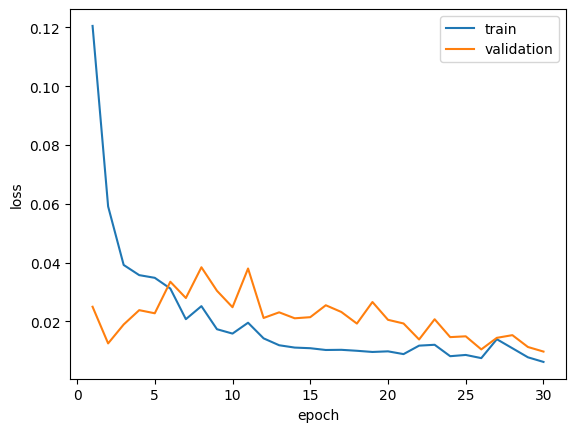

In [12]:
plt.plot([i for i in range(1, epochs+1)], train_history.history['loss'], label='train')
plt.plot([i for i in range(1, epochs+1)], train_history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()